<a href="https://colab.research.google.com/github/ArnovanHilten/GenNet/blob/master/Proof_of_Concept_GenNet_Non_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proof of Concept GenNet


1. Copy to playground
2. Press Runtime > Run all or ctrl + F9

## Initialization

In [ ]:
#@title [Temporary] Installing correct tensorflow { display-mode: "form" }
%%capture

!pip install tensorflow==1.13.1
import tensorflow as tf
print(tf.__version__)

In [ ]:
#@title Importing python modules { display-mode: "form" }

import tensorflow as tf
import os
from scipy.sparse import coo_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
import sklearn.metrics as skm
import scipy
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as Kb
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import InputSpec
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.util.tf_export import tf_export


In [ ]:
#@title Locally-Directed1D layer
"""Locally-Directed1D layer.
"""



@tf_export('keras.layers.LocallyDirected1D')
class LocallyDirected1D(Layer):
    """Locally-Directed1D layer for 1D inputs.

  The `LocallyDirected1D` layer works similarly to
  the `Conv1D` layer, except that weights are unshared,
  that is, a different set of filters is applied at each different patch
  of the input.

  Example:
  ```python
      # apply a unshared weight convolution 1d of length 3 to a sequence with
      # 10 timesteps, with 64 output filters
      model = Sequential()
      model.add(LocallyDirected1D(64, 3, input_shape=(10, 32)))
      # now model.output_shape == (None, 8, 64)
      # add a new conv1d on top
      model.add(LocallyDirected1D(32, 3))
      # now model.output_shape == (None, 6, 32)
  ```

  Arguments:
      mask: sparse matrix with shape (input, output) connectivity matrix,
            True defines connection between (in_i, out_j), should be sparse (False,0) >> True
            should be scipy sparese matrix in COO Format!
      filters: Integer, the dimensionality of the output space
          (i.e. the number of output filters in the convolution).
      kernel_size: An integer or tuple/list of a single integer,
          specifying the length of the 1D convolution window.
      strides: An integer or tuple/list of a single integer,
          specifying the stride length of the convolution.
          Specifying any stride value != 1 is incompatible with specifying
          any `dilation_rate` value != 1.
      padding: Currently only supports `"valid"` (case-insensitive).
          `"same"` may be supported in the future.
      data_format: A string,
          one of `channels_last` (default) or `channels_first`.
          The ordering of the dimensions in the inputs.
          `channels_last` corresponds to inputs with shape
          `(batch, length, channels)` while `channels_first`
          corresponds to inputs with shape
          `(batch, channels, length)`.
          It defaults to the `image_data_format` value found in your
          Keras config file at `~/.keras/keras.json`.
          If you never set it, then it will be "channels_last".
      activation: Activation function to use.
          If you don't specify anything, no activation is applied
          (ie. "linear" activation: `a(x) = x`).
      use_bias: Boolean, whether the layer uses a bias vector.
      kernel_initializer: Initializer for the `kernel` weights matrix.
      bias_initializer: Initializer for the bias vector.
      kernel_regularizer: Regularizer function applied to
          the `kernel` weights matrix.
      bias_regularizer: Regularizer function applied to the bias vector.
      activity_regularizer: Regularizer function applied to
          the output of the layer (its "activation")..
      kernel_constraint: Constraint function applied to the kernel matrix.
      bias_constraint: Constraint function applied to the bias vector.

  Input shape:
      3D tensor with shape: `(batch_size, steps, input_dim)`

  Output shape:
      3D tensor with shape: `(batch_size, new_steps, filters)`
      `steps` value might have changed due to padding or strides.
  """

    def __init__(self,
                 mask,
                 filters,
                 padding='valid',
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(LocallyDirected1D, self).__init__(**kwargs)
        self.filters = filters
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=3)
        self.mask = mask

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            input_dim, input_length = input_shape[1], input_shape[2]
        else:
            input_dim, input_length = input_shape[2], input_shape[1]

        if input_dim is None:
            raise ValueError('Axis 2 of input should be fully-defined. '
                             'Found shape:', input_shape)
        self.output_length = self.mask.shape[1]
        print("output length is " + str(self.output_length))
        if self.data_format == 'channels_first':
            self.kernel_shape = (input_dim, input_length,
                                 self.filters, self.output_length)
        else:
            self.kernel_shape = (input_length, input_dim,
                                 self.output_length, self.filters)


        self.kernel = self.add_weight(shape=(len(self.mask.data),),    #sum of all nonzero values in mask sum(sum(mask))
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        self.kernel_mask = get_locallyDirected1D_mask(self.mask,self.kernel,
            data_format=self.data_format,
            dtype=self.kernel.dtype
        )


        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.output_length, self.filters),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None

        if self.data_format == 'channels_first':
            self.input_spec = InputSpec(ndim=3, axes={1: input_dim})
        else:
            self.input_spec = InputSpec(ndim=3, axes={-1: input_dim})
        self.built = True


    def call(self, inputs):

        # output = local_conv_matmul(inputs, self.kernel_mask,
        #                            self.output_length)

        output = local_conv_matmul_sparse(inputs, self.kernel_mask,
                                          self.output_length, self.filters)



        if self.use_bias:
            output = Kb.bias_add(output, self.bias, data_format=self.data_format)

        output = self.activation(output)
        return output

    def get_config(self):  # delete this?
        config = {
            'filters':
                self.filters,
            'padding':
                self.padding,
            'data_format':
                self.data_format,
            'activation':
                activations.serialize(self.activation),
            'use_bias':
                self.use_bias,
            'kernel_initializer':
                initializers.serialize(self.kernel_initializer),
            'bias_initializer':
                initializers.serialize(self.bias_initializer),
            'kernel_regularizer':
                regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer':
                regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            'kernel_constraint':
                constraints.serialize(self.kernel_constraint),
            'bias_constraint':
                constraints.serialize(self.bias_constraint),
        }
        base_config = super(LocallyDirected1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



def get_locallyDirected1D_mask(mask, kernel, data_format,
                              dtype):
    """Return a mask representing connectivity of a locally-connected operation.

  This method returns a masking tensor of 0s and 1s (of type `dtype`) that,
  when element-wise multiplied with a fully-connected weight tensor, masks out
  the weights between disconnected input-output pairs and thus implements local
  connectivity through a sparse fully-connected weight tensor.

  Assume an unshared convolution with given parameters is applied to an input
  having N spatial dimensions with `input_shape = (d_in1, ..., d_inN)`
  to produce an output with spatial shape `(d_out1, ..., d_outN)` (determined
  by layer parameters such as `strides`).

  This method returns a mask which can be broadcast-multiplied (element-wise)
  with a 2*(N+1)-D weight matrix (equivalent to a fully-connected layer between
  (N+1)-D activations (N spatial + 1 channel dimensions for input and output)
  to make it perform an unshared convolution with given `kernel_shape`,
  `strides`, `padding` and `data_format`.

  Arguments:
    mask: sparse connectivity matrix matrix
    kernel: weights with len(sum(non-sparse values)
    data_format: a string, `"channels_first"` or `"channels_last"`.
    dtype: type of the layer operation, e.g. `tf.float64`.

  Returns:
    a `dtype`-tensor of shape
    `(1, d_in1, ..., d_inN, 1, d_out1, ..., d_outN)`
    if `data_format == `"channels_first"`, or
    `(d_in1, ..., d_inN, 1, d_out1, ..., d_outN, 1)`
    if `data_format == "channels_last"`.

    Adaption by arno is now a sparse matrix.
  Raises:
    ValueError: if `data_format` is neither `"channels_first"` nor
                `"channels_last"`.
  """

    ndims = int(mask.ndim / 2)
    indices = np.mat([mask.row, mask.col]).transpose()
    print(mask.shape)
    mask = tf.SparseTensor(indices, kernel, [mask.shape[0],mask.shape[1]])

    if data_format == 'channels_first':
        mask = tf.sparse.expand_dims(mask, 0)
        mask = tf.sparse.expand_dims(mask, - ndims - 1)

    elif data_format == 'channels_last':
        mask = tf.sparse.expand_dims(mask, ndims)
        mask = tf.sparse.expand_dims(mask, -1)

    else:
        raise ValueError('Unrecognized data_format: ' + str(data_format))

    return mask


def local_conv_matmul_sparse(inputs, kernel_mask, output_length, filters):
    """Apply N-D convolution with un-shared weights using a single matmul call.

  This method outputs `inputs . (kernel * kernel_mask)`
  (with `.` standing for matrix-multiply and `*` for element-wise multiply)
  and requires a precomputed `kernel_mask` to zero-out weights in `kernel` and
  hence perform the same operation as a convolution with un-shared
  (the remaining entries in `kernel`) weights. It also does the necessary
  reshapes to make `inputs` and `kernel` 2-D and `output` (N+2)-D.

  Arguments:
      inputs: (N+2)-D tensor with shape
          `(batch_size, channels_in, d_in1, ..., d_inN)`
          or
          `(batch_size, d_in1, ..., d_inN, channels_in)`.
      kernel: the unshared weights for N-D convolution,
          an (N+2)-D tensor of shape:
          `(d_in1, ..., d_inN, channels_in, d_out2, ..., d_outN, channels_out)`
          or
          `(channels_in, d_in1, ..., d_inN, channels_out, d_out2, ..., d_outN)`,
          with the ordering of channels and spatial dimensions matching
          that of the input.
          Each entry is the weight between a particular input and
          output location, similarly to a fully-connected weight matrix.
      kernel_mask: a float 0/1 mask tensor of shape:
           `(d_in1, ..., d_inN, 1, d_out2, ..., d_outN, 1)`
           or
           `(1, d_in1, ..., d_inN, 1, d_out2, ..., d_outN)`,
           with the ordering of singleton and spatial dimensions
           matching that of the input.
           Mask represents the connectivity pattern of the layer and is
           precomputed elsewhere based on layer parameters: stride,
           padding, and the receptive field shape.
      output_shape: a tuple of (N+2) elements representing the output shape:
          `(batch_size, channels_out, d_out1, ..., d_outN)`
          or
          `(batch_size, d_out1, ..., d_outN, channels_out)`,
          with the ordering of channels and spatial dimensions matching that of
          the input.

  Returns:
      Output (N+2)-D tensor with shape `output_shape`.
  """
    inputs_flat = Kb.reshape(inputs, (Kb.shape(inputs)[0], -1))
    kernel_mask = make_2d_sparse(kernel_mask, split_dim=Kb.ndim(kernel_mask) // 2)
    output_flat = tf.sparse.matmul(kernel_mask,inputs_flat, adjoint_a=True, adjoint_b=True)
    output_flat = tf.transpose(output_flat)
    output = Kb.reshape(output_flat, [-1, output_length, filters])

    return output



def make_2d_sparse(tensor, split_dim):
    """Reshapes an N-dimensional tensor into a 2D tensor.

  Dimensions before (excluding) and after (including) `split_dim` are grouped
  together.

  Arguments:
    tensor: a tensor of shape `(d0, ..., d(N-1))`.
    split_dim: an integer from 1 to N-1, index of the dimension to group
        dimensions before (excluding) and after (including).

  Returns:
    Tensor of shape
    `(d0 * ... * d(split_dim-1), d(split_dim) * ... * d(N-1))`.
  """

    shape = Kb.array_ops.shape(tensor)
    in_dims = shape[:split_dim]
    out_dims = shape[split_dim:]

    in_size = Kb.math_ops.reduce_prod(in_dims)
    out_size = Kb.math_ops.reduce_prod(out_dims)

    return tf.sparse.reshape(tensor, (in_size, out_size))



def local_conv_matmul(inputs, kernel_mask, output_length):
    """Apply N-D convolution with un-shared weights using a single matmul call.

  This method outputs `inputs . (kernel * kernel_mask)`
  (with `.` standing for matrix-multiply and `*` for element-wise multiply)
  and requires a precomputed `kernel_mask` to zero-out weights in `kernel` and
  hence perform the same operation as a convolution with un-shared
  (the remaining entries in `kernel`) weights. It also does the necessary
  reshapes to make `inputs` and `kernel` 2-D and `output` (N+2)-D.

  Arguments:
      inputs: (N+2)-D tensor with shape
          `(batch_size, channels_in, d_in1, ..., d_inN)`
          or
          `(batch_size, d_in1, ..., d_inN, channels_in)`.
      kernel: the unshared weights for N-D convolution,
          an (N+2)-D tensor of shape:
          `(d_in1, ..., d_inN, channels_in, d_out2, ..., d_outN, channels_out)`
          or
          `(channels_in, d_in1, ..., d_inN, channels_out, d_out2, ..., d_outN)`,
          with the ordering of channels and spatial dimensions matching
          that of the input.
          Each entry is the weight between a particular input and
          output location, similarly to a fully-connected weight matrix.
      kernel_mask: a float 0/1 mask tensor of shape:
           `(d_in1, ..., d_inN, 1, d_out2, ..., d_outN, 1)`
           or
           `(1, d_in1, ..., d_inN, 1, d_out2, ..., d_outN)`,
           with the ordering of singleton and spatial dimensions
           matching that of the input.
           Mask represents the connectivity pattern of the layer and is
           precomputed elsewhere based on layer parameters: stride,
           padding, and the receptive field shape.
      output_shape: a tuple of (N+2) elements representing the output shape:
          `(batch_size, channels_out, d_out1, ..., d_outN)`
          or
          `(batch_size, d_out1, ..., d_outN, channels_out)`,
          with the ordering of channels and spatial dimensions matching that of
          the input.

  Returns:
      Output (N+2)-D tensor with shape `output_shape`.
  """
    inputs_flat = Kb.reshape(inputs, (Kb.shape(inputs)[0], -1))

    kernel = make_2d_sparse(kernel_mask, split_dim=Kbndim(kernel_mask) // 2)


    output_flat = tf.sparse_tensor_dense_matmul(inputs_flat, kernel, b_is_sparse=True)


    output = Kb.reshape(output_flat, [-1, output_length, 1])
    return output


def make_2d(tensor, split_dim):
    """Reshapes an N-dimensional tensor into a 2D tensor.

  Dimensions before (excluding) and after (including) `split_dim` are grouped
  together.

  Arguments:
    tensor: a tensor of shape `(d0, ..., d(N-1))`.
    split_dim: an integer from 1 to N-1, index of the dimension to group
        dimensions before (excluding) and after (including).

  Returns:
    Tensor of shape
    `(d0 * ... * d(split_dim-1), d(split_dim) * ... * d(N-1))`.
  """
    print(tensor.shape)
    shape = Kb.array_ops.shape(tensor)
    in_dims = shape[:split_dim]
    out_dims = shape[split_dim:]

    in_size = Kb.math_ops.reduce_prod(in_dims)
    out_size = Kb.math_ops.reduce_prod(out_dims)

    return Kb.array_ops.reshape(tensor, (in_size, out_size))


# %%






In [ ]:
#@title Utility functions { display-mode: "form" }
#

tf.keras.backend.set_epsilon(0.00001)
global weight_negative_class
global weight_possitive_class
global data_path

def weighted_binary_crossentropy(y_true, y_pred):
    y_true = K.backend.clip(y_true, 0.0001, 1)
    y_pred = K.backend.clip(y_pred, 0.0001, 1)

    return K.backend.mean(
        -y_true * K.backend.log(y_pred + 0.0001) * weight_possitive_class - (1 - y_true) * K.backend.log(
            1 - y_pred + 0.0001) * weight_negative_class)



def progressBar(value, end_value, bar_length=50):
    percent = float(value + 1) / end_value
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))

    if value >= end_value:
        sys.stdout.write("\n")

    sys.stdout.flush()


def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 0, 1)
    y_true = tf.keras.backend.clip(y_true, 0, 1)

    y_pred = tf.keras.backend.round(y_pred)

    true_p = K.backend.sum(K.backend.round(y_pred) * y_true)
    pos = tf.keras.backend.sum(y_true)
    sensitivity1 = tf.keras.backend.clip((true_p / (pos + 0.00001)), 0, 1)
    return sensitivity1

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 0, 1)
    y_true = tf.keras.backend.clip(y_true, 0, 1)

    neg_y_true = 1 - y_true
    neg_y_pred = 1 - K.backend.round(y_pred)
    fp = K.backend.sum(neg_y_true * K.backend.round(y_pred))
    tn = K.backend.sum(neg_y_true * neg_y_pred)
    specificity1 = tn / (tn + fp + 0.00001)
    return tf.keras.backend.clip(specificity1, 0, 1)


def evaluate_performance(y,p):
    print("\n")
    print("Confusion matrix")
    confusion_matrix = skm.confusion_matrix(y, p.round())
    print(confusion_matrix)

    fpr, tpr, thresholds = skm.roc_curve(y, p)
    roc_auc = skm.auc(fpr, tpr)
    print("\n")
    print("Area under the Curve (AUC) = ", roc_auc)

    specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
    print('Specificity = ', specificity)

    sensitivity = confusion_matrix[1, 1] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])
    print('Sensitivity = ', sensitivity)
    print("F_1 score = " + str(skm.f1_score(y, p.round())))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(1 - specificity, sensitivity, color='b', marker='o')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



## Parameters



In [ ]:
jobid = 1
modeltype = "sparse_directed_gene"
weight_possitive_class = 1 
weight_negative_class = 1
batch_size = 32
startindex = 0
stopindex = -1
inputsize = 100
max_id = 10
train_size = 4000
val_size = 2000
test_size = 2000
epochs = 10
optimizer = tf.keras.optimizers.Adadelta()


## Create data, mask and network

In [ ]:
#@title Functions
def get_simdata(num_patients=100, num_features=100,
                    ind_linked=[   [[0, 0], [4, 2]],   [[6, 2], [9, 0]], 
                                   [[12, 2], [19, 2]],   [[21, 2], [29, 0]], [[35, 0], [45, 2]] ] # causal SNPs
                    , n=2, p=0.3,
                    random_seed=42):
    
    
    np.random.seed(random_seed)
    basis = np.zeros([num_patients, num_features])
    effectsize = 1

    for k in range(num_features):
        basis[:, k] = np.random.binomial(n, p, num_patients)

    status = np.zeros(num_patients)
    for patient in range(num_patients):
        for linked in ind_linked:
            temp = np.zeros([len(linked)])
            i = 0
            for element in linked:
                if basis[patient, element[0]] == element[1]:
                    temp[i] = 1
                i += 1
            if np.min(temp) > 0:
                status[patient] = 1



    num_diseased = np.sum(status)
    causal_snps = [[x[0][0] for x in ind_linked],[x[1][0] for x in ind_linked]]
    print(("Created dataset[", num_patients, " x ", num_features, "] with", num_diseased, "diseased"))
    return basis, status,causal_snps

def sparse_directed_gene(inputsize, mask):
    inputs_ = K.Input((inputsize,), name='inputs_')

    Input_layer = K.layers.Reshape(input_shape=(inputsize,), target_shape=(inputsize, 1))(inputs_)
    Gene_layer = LocallyDirected1D(mask=mask, filters=1, input_shape=(inputsize, 1), name="gene_layer",)(Input_layer)
    Gene_layer = K.layers.Flatten()(Gene_layer)
    Gene_layer = K.layers.Activation("tanh")(Gene_layer)

    BatchNorm = K.layers.BatchNormalization(center=False, scale=False, name="inter_out")(Gene_layer)
    
    Prediction_layer = K.layers.Dense(units=1,    kernel_regularizer=K.regularizers.l1(0.01) )(BatchNorm)
    Prediction_layer = K.layers.Activation("sigmoid")(Prediction_layer)
    model = K.Model(inputs=inputs_, outputs=Prediction_layer)
    return model

def make_mask_gene_layer(inputsize):
    mask_d  = np.zeros((inputsize,10), np.bool)
    mask_d[0:5,0]= True
    mask_d[5:10,1]= True
    mask_d[10:20,2]=True
    mask_d[20:30,3]=True
    mask_d[30:50,4]=True
    mask_d[50:70,5]= True
    mask_d[70:80,6]= True
    mask_d[80:90,7]=True
    mask_d[90:95,8]=True
    mask_d[95:100,9]=True
    mask =  coo_matrix(mask_d)
    gene_end =[0,5,10,20,30,50,70,80,90,95,100]  
    return mask, gene_end


## Train and evaluate network


output length is 10
(100, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_ (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape (Reshape)            (None, 100, 1)            0         
_________________________________________________________________
gene_layer (LocallyDirected1 (None, 10, 1)             110       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
inter_out (BatchNormalizatio (None, 10)                20        
_________________________________________________________________
dense (Dense)                (None, 1)        

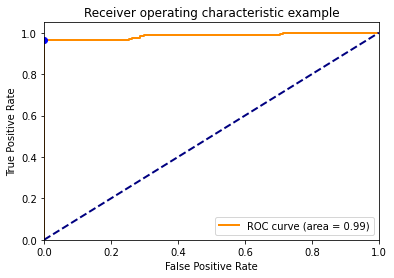

In [ ]:
genemask, gene_end = make_mask_gene_layer(inputsize)

model = sparse_directed_gene(inputsize=int(inputsize), mask=genemask)
model.compile(loss=weighted_binary_crossentropy, optimizer="adadelta", metrics=["accuracy", sensitivity, specificity])
print(model.summary())

xtrain, ytrain, causal_snps =get_simdata(num_features=inputsize,num_patients=train_size, random_seed=1+ jobid)
xval, yval, _ =get_simdata(num_features=inputsize,num_patients=val_size, random_seed=21 + jobid)

earlystop = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)
model.fit(x=xtrain, y=ytrain, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[earlystop], validation_data=(xval,yval), shuffle=True)


pval = model.predict(xval)

evaluate_performance(yval, pval)



evaluate over test patients
('Created dataset[', 2000, ' x ', 100, '] with', 344.0, 'diseased')


Confusion matrix
[[1656    0]
 [  14  330]]


Area under the Curve (AUC) =  0.9821666807100324
Specificity =  1.0
Sensitivity =  0.9593023255813954
F_1 score = 0.9792284866468843


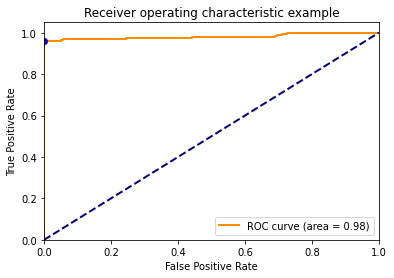

In [ ]:
print("evaluate over test patients")
xtest, ytest, _ = get_simdata(num_features=inputsize, num_patients=test_size, random_seed=12+ jobid)
ptest = model.predict(xtest)
evaluate_performance(ytest, ptest)

## Compare with logistic regression 



Confusion matrix
[[1571   85]
 [ 224  120]]


Area under the Curve (AUC) =  0.6487543534434334
Specificity =  0.9486714975845411
Sensitivity =  0.3488372093023256
F_1 score = 0.4371584699453552


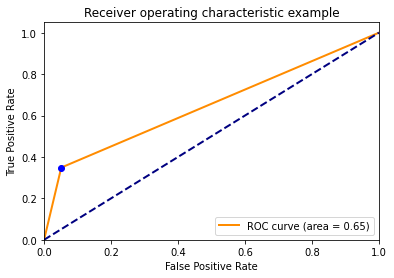

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(xtrain, ytrain)
ptest_lr = clf.predict(xtest)

evaluate_performance(ytest, ptest_lr)

In [ ]:
betas_lr = pd.DataFrame(clf.coef_[:].T, columns=["Betas logistic regression"])
betas_lr_s = betas_lr.sort_values("Betas logistic regression",ascending=False)
print("Causal SNPs are:", causal_snps)
betas_lr_s.head(12)




Causal SNPs are: [[0, 6, 12, 21, 35], [4, 9, 19, 29, 45]]


,Betas logistic regression
21,1.292919
4,1.228836
45,1.174449
6,1.065161
12,0.330148
70,0.236455
65,0.159064
85,0.147308
40,0.144457
36,0.134665


## Plot network

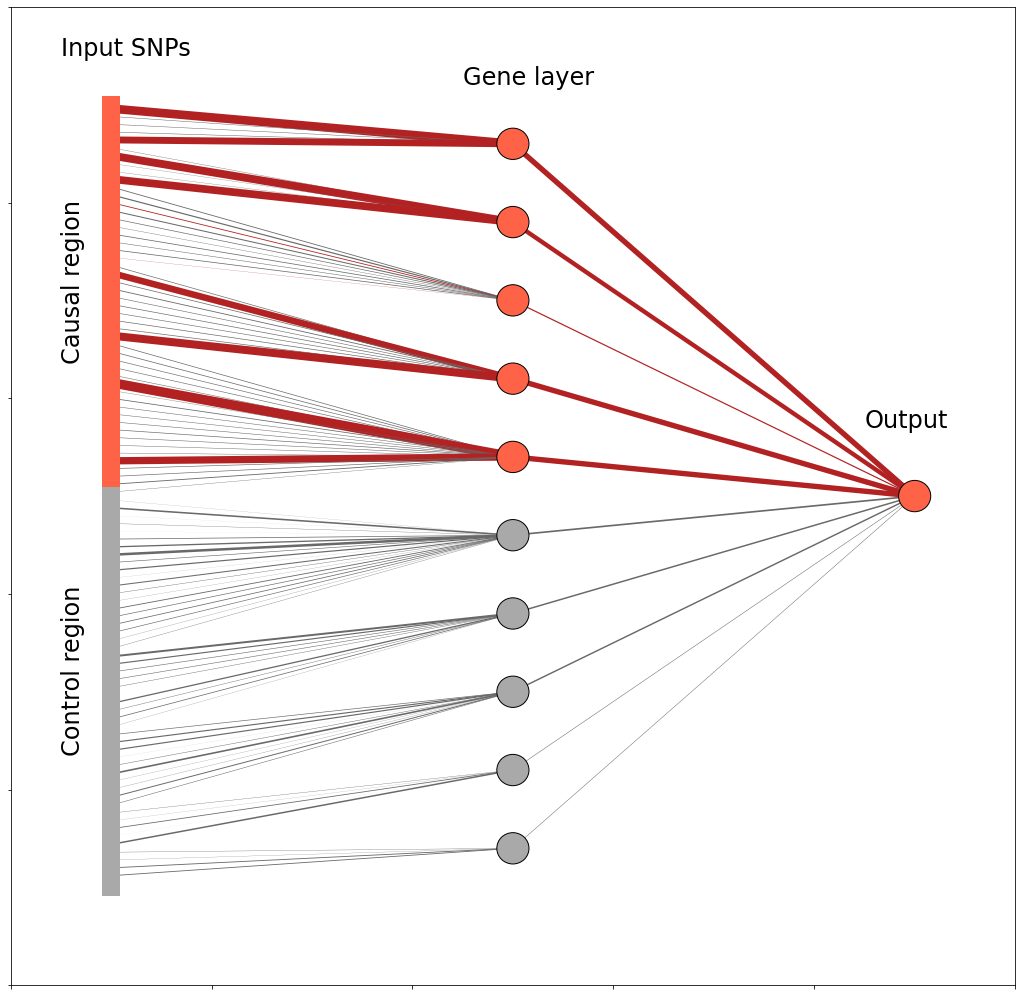

In [ ]:
#@title Plot network 
from matplotlib import cm
import matplotlib.patches as mpatches

weight_locally = model.layers[2].get_weights()[0]
weights_dense = model.layers[5].get_weights()[0]

causal_snps = np.array(causal_snps)
colors = plt.cm.tab10(np.linspace(0,1,10))
fig = plt.figure(figsize=(18, 18))

n_layers = 3
gene_mask = genemask.todense()
layer_sizes = [genemask.shape[0], genemask.shape[1], 1]


ax = fig.gca()
top=0.9
bottom=0.1
left = 0.1
right = 0.9
                 
v_spacing = (top - bottom)/float(max(layer_sizes))
h_spacing = (right - left)/float(len(layer_sizes) - 1)


causal_red = "firebrick" #"#7dcfe2"
causal_circle_red = "tomato" #"#4b78b5"
gray1 = "darkgrey"
gray2 = "dimgray"

linewith_genes = (weights_dense * 5 + 0.5)
linewith_snps = (weight_locally* 5+0.5)
colormap_snps = np.zeros(inputsize, dtype=object)
colormap_snps[:] =gray2
colormap_snps[causal_snps] = causal_red
colormap_genes = np.zeros((gene_mask.shape[1]), dtype=object)
colormap_genes[:int(len(colormap_genes)/2)] = causal_red
colormap_genes[int(len(colormap_genes)/2):] = gray2
colormap_circle_genes = np.zeros((gene_mask.shape[1]), dtype=object)
colormap_circle_genes[:int(len(colormap_circle_genes)/2)] = causal_circle_red
colormap_circle_genes[int(len(colormap_circle_genes)/2):] = gray1



#SNPs
n=0    
layer_size = layer_sizes[0]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2

y_snps=[]
layer_size_a = gene_mask.shape[0]
layer_size_b = gene_mask.shape[1]
layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
for m in range(layer_size):
    y_snps.append(layer_top_a - m*v_spacing) 
        
line_vert_1 =plt.Line2D(xdata=[n*h_spacing + left, n*h_spacing + left],
                                  ydata=[top, ((top-bottom)/2)+bottom ],
                                  c=causal_circle_red, linewidth = "18")


line_vert_2 =plt.Line2D(xdata=[n*h_spacing + left, n*h_spacing + left],
                                  ydata=[((top-bottom)/2)+bottom, bottom],
                                  c=gray1 , linewidth = "18")




## Gene layer
layer_sizes2 = [genemask.shape[1], 1]
v_spacing = (top - bottom)/float(max(layer_sizes2))



n=1
layer_size = layer_sizes[1]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2

layer2xy = []
for m in range(layer_size):
    layer2xy.append( (n*h_spacing + left, layer_top - m*v_spacing))
    circle = plt.Circle(xy=layer2xy[m], radius=v_spacing/5,
                        color=colormap_circle_genes[m], ec='k', zorder=4)
    ax.add_artist(circle)

    
## Dense layer

n=2
layer_size = layer_sizes[2]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2


for m in range(layer_size):
    circle = plt.Circle(xy=(n*h_spacing + left, layer_top - m*v_spacing), radius=v_spacing/5,
                         color = causal_circle_red, ec='k', zorder=4)
    ax.add_artist(circle)   



# draw lines    
teller_snp_lines = 0
for column in range(gene_mask.shape[1]):
    rows = np.where(gene_mask[:,column]!=0)
    for row in rows[0]:
            line = plt.Line2D(xdata=[left,        layer2xy[column][0]],
                              ydata=[y_snps[row], layer2xy[column][1]],
                              c = colormap_snps[teller_snp_lines], linewidth = linewith_snps[teller_snp_lines])
            ax.add_artist(line)
            teller_snp_lines +=1
            
for column in range(gene_mask.shape[1]):
        line = plt.Line2D(xdata=[layer2xy[column][0],right],
                          ydata=[layer2xy[column][1], layer_top - m*v_spacing],
                          c = colormap_genes[column], linewidth = linewith_genes[column])
        ax.add_artist(line)



plt.annotate("Control region" ,xy=(left/2,0.24), size = 24, rotation = "90")
plt.annotate("Causal region", xy=(left/2,0.64), size=24, rotation = "90")
plt.annotate("Input SNPs", xy=(left-0.05,0.95), size=24, rotation = "0")
plt.annotate("Gene layer", xy=(layer2xy[0][0]-0.05,0.92), size=24)
plt.annotate("Output", xy=(right-0.05,0.57), size=24)
        
ax.add_artist(line_vert_1)
ax.add_artist(line_vert_2)
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
